<font size="+2"><h1>Diffusion-limited aggregation</h1></font>

<p style='text-align: justify;  line-height: 1.6;'>This project is inspired by a course project I did a while ago, which aimed to simulate diffusion-limited aggregation in two dimensions. It followed the procedure of Witten and Sander which tried to model a limit of dendritic growth <cite data-cite="9089331/WZ6SRZ6K"></cite>. In two dimensions, the simulation takes place on a $2^k \times 2^k$ lattice, so that each point is defined by coordinates ($x, y$). An inner and and an outer circle are then defined, with the latter being the boundary of the system, i.e. particles that diffuse outside of the outer circle are 'lost'. The inner circle is the starting point for diffusion, which is modeled by a random walk. Only one random walker at a time is released and the walk can either be ended by diffusion outside of the system (leaving the outer circle) or by hitting a pre-defined seed in the middle of the inner circle. If this is the case, the random walker will attach to the seed and a new walker will be released; now the new walker can 'hit' the initial seed or to the first walker attached to it etc. and the model grows.</p>

<p style='text-align: justify; line-height: 1.6;'>I thought it would be a good idea to both revisit the old script I wrote back then and improve on it, but also to extend the assignment to include three dimensions as a challenge. The old script can be found in <i>dla.py</i>. For the new version, I decided to write a package that would include all the methods needed for the simulation - initializing the system, carrying out the random walk etc. The package is called dla_3d and contains two classes, <i>initialize_system</i> and <i>random_walk</i>. Detailed documentation of the methods can be found in the <a href="https://radostmilena.github.io/index.html">package documentation</a> or in the docs folder on GitHub. In short, the first class will create an empty grid with (integer) coordinates ($x, y, z$), find the center of the grid and fill it by setting the value of that point to one. The second class contains three functions, one will initialize the random walk in a random position on the inner circle (now sphere) and another will check the surroundings of a point for filled points and calculate the distance to the center. Both functions are used by the third function which carries out the random walk. Walkers can only step next to, above or below their current position, i.e. only coordinate changes of one like ($x, y, z+1$) are possible, but not more, so ($x+1, y, z+1$) would not be a valid step. After each step, the function to check the surrounding grid points is called to evaluate if the walker has hit a seed or left the outer circle (now sphere).</p>

<p style='text-align: justify; line-height: 1.6;'>The radii of the inner and outer sphere are defined by the user, as is the size of the grid when initializing the system (<i>initialize_system</i> takes as input $k$, the exponent). A random walk on a $2^6 \times 2^6 \times 2^6$ grid using $35000$ random walkers would then look something like this:</p>

<p style='text-align: justify; line-height: 1.6;'>(This is the code you will also find in _main.py_, I could not get this to work in Jupyter, so I decided to split the simulation and the plotting and do the former in Python 3 and the latter in Jupyter.)</p>

The _dla_3d_ package was tested before running this, the test functions can be found in the testing branch.

<p style='text-align: justify; line-height: 1.6;'>A file called _grid.dat.npy_ will be written at the end of the simulation, which can now be imported into Jupyter and plotted. The performance of the simulation script was also evaluated using line profiling and it was found that the checking function was the most time-consuming step. An effort to cythonize it to speed up the calculation showed no improvement however, suggesting that the performance is limited by statistics more than by its implementation.</p>

After testing, running and profiling the results can now be plotted. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

<p style='text-align: justify; line-height: 1.6;'>To plot the grid points in three dimensions I could not find a matplotlib class or function that would do this using cubes, so I wrote this little function that plots the six faces of a cube around the coordinates of a given grid point.</p>

In [2]:
def drawFace(x, y, z, f):
    i = 0.5
    if f == 1:
        arrays = [[x-i, y-i, z+i], [x+i, y-i, z+i], [x+i, y+i, z+i], [x-i, y+i, z+i]]
    elif f == 2:
        arrays = [[x-i, y-i, z-i], [x+i, y-i, z-i], [x+i, y+i, z-i], [x-i, y+i, z-i]]
    elif f == 3:
        arrays = [[x-i, y-i, z+i], [x+i, y-i, z+i], [x+i, y-i, z-i], [x-i, y-i, z-i]]
    elif f == 4:
        arrays = [[x-i, y-i, z+i], [x-i, y+i, z+i], [x-i, y+i, z-i], [x-i, y-i, z-i]]
    elif f == 5:
        arrays = [[x+i, y+i, z+i], [x-i, y+i, z+i], [x-i, y+i, z-i], [x+i, y+i, z-i]]
    else: 
        arrays = [[x+i, y-i, z+i], [x+i, y+i, z+i], [x+i, y+i, z-i], [x+i, y-i, z-i]]
    x = []
    y = []
    z = []
    for i in range(0, len(arrays), 1):
        x.append(arrays[i][0])
        y.append(arrays[i][1])
        z.append(arrays[i][2])
    return (x, y, z)

<p style='text-align: justify; line-height: 1.6;'>The grid containing the grown structure after the simulation can be loaded directly. Since I only need to plot the elements of the grid that are one, it can be split afterwards to contain only the points that are non-zero. The number of points in this sub-array can also give insight into the statistics of growth.</p>

In [3]:
grid = np.load('grid.dat.npy')
array = grid.nonzero()
print(len(array[0]))

1046


<p style='text-align: justify; line-height: 1.6;'>Here, for example, we see that only 1046 of the 35000 random walkers that were released actually hit another point and were added to the structure, which is roughly $3\%$ of them. In other runs, this could go up to $5\%$, but hardly higher, meaning that the vast majority of random walkers leave the system rather than attach to a seed. This might explain why cythonizing led to no significant speed-up in the calculation.</p>

Now, we can simply plot the non-zero elements in a 3D plot and get a nice figure.

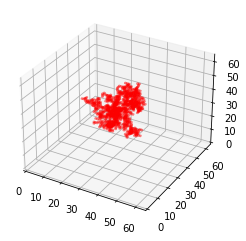

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0, len(array[0]), 1):
    xi = array[0][i]
    yi = array[1][i]
    zi = array[2][i]
    for j in range(1, 7, 1):
        (x, y, z) = drawFace(xi, yi, zi, j)
        verts = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(verts, facecolor='r', alpha=0.3))
ax.set_xlim(0, 64)
ax.set_ylim(0, 64)
ax.set_zlim(0, 64)
plt.savefig('dla.pdf')

<p style='text-align: justify; line-height: 1.6;'>The result resembles the fractal structures that are found in 2D aggregation. We can therefore assume that this is a fairly adequate model of the same process in three dimensions and the package does what is supposed to do.</p>

**References**

<div class="cite2c-biblio"></div>